In [1]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten, TextVectorization, GlobalMaxPool1D, Conv1D
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import History 
history = History()

In [2]:
import pandas as pd

df = pd.read_csv('../data/data.csv', delimiter='|')

In [3]:
from sklearn.model_selection import train_test_split

df['label'] = df['category'].apply(lambda x: 1 if x == 'ChatGPT' else 0)

y = df['label'].values
df["text"] = df['text'].apply(lambda x: str(x))
X = df['text'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
max_features = 5000
max_len = 100
vectorize_layer = TextVectorization(
  max_tokens=max_features,
  output_mode='int',
  output_sequence_length=max_len)

In [ ]:
text_dataset = tf.data.Dataset.from_tensor_slices(X_train)
vectorize_layer.adapt(text_dataset.batch(64))

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

model.add(tf.keras.layers.Embedding(max_features + 1, 128))

# Convulutional layer
model.add(Conv1D(128, kernel_size=(3), activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Flatten())

# Fully connected layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[history])

Epoch 1/50
530/530 [==============================] - 7s 12ms/step - loss: 0.2282 - accuracy: 0.9110
Epoch 2/50
530/530 [==============================] - 6s 12ms/step - loss: 0.0850 - accuracy: 0.9736
Epoch 3/50
530/530 [==============================] - 7s 12ms/step - loss: 0.0441 - accuracy: 0.9887
Epoch 4/50
530/530 [==============================] - 7s 12ms/step - loss: 0.0307 - accuracy: 0.9912
Epoch 5/50
530/530 [==============================] - 7s 12ms/step - loss: 0.0161 - accuracy: 0.9954
Epoch 6/50
530/530 [==============================] - 7s 13ms/step - loss: 0.0152 - accuracy: 0.9948
Epoch 7/50
530/530 [==============================] - 7s 12ms/step - loss: 0.0108 - accuracy: 0.9968
Epoch 8/50
530/530 [==============================] - 6s 12ms/step - loss: 0.0110 - accuracy: 0.9963
Epoch 9/50
530/530 [==============================] - 7s 12ms/step - loss: 0.0078 - accuracy: 0.9974
Epoch 10/50
530/530 [==============================] - 7s 12ms/step - loss: 0.0070 - accura

In [15]:
import json

with open('../frontend/src/data/training.json', 'w') as f:
  f.write(json.dumps(history.history))

In [10]:
import json

predictions = model.predict(X_test)

results = {
  "ai": {
    "correct": [],
    "incorrect": []
  },
  "human": {
    "correct": [],
    "incorrect": []
  }
}
for i in range(len(predictions)):
    if y_test[i] == 1:
      if predictions[i] > 0.5:
        results["ai"]["correct"].append(X_test[i])
      else:
        results["ai"]["incorrect"].append(X_test[i])
    if y_test[i] == 0:
      if predictions[i] < 0.5:
        results["human"]["correct"].append(X_test[i])
      else:
        results["human"]["incorrect"].append(X_test[i])

print(f"Percentage Correct: {round(((len(results['ai']['correct']) + len(results['human']['correct'])) / len(predictions)) * 100)}")

with open('../frontend/src/data/results.json', 'w') as f:
  data_obj = {
    "ai": {"correct": len(results["ai"]["correct"]), "incorrect": len(results["ai"]["incorrect"])},
    "human": {"correct": len(results["human"]["correct"]), "incorrect": len(results["human"]["incorrect"])}
  }
  json.dump(data_obj, f)

265/265 [==============================] - 1s 3ms/step
Percentage Correct: 96


AI Results: 95%
Human Results: 96%


<BarContainer object of 4 artists>

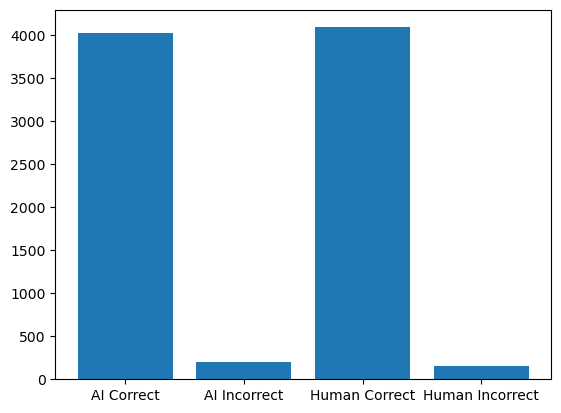

In [21]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["AI Correct", "AI Incorrect", "Human Correct", "Human Incorrect"])
y = np.array([len(results["ai"]["correct"]), len(results["ai"]["incorrect"]), len(results["human"]["correct"]), len(results["human"]["incorrect"])])

print(f"AI Results: {round((len(results['ai']['correct']) / (len(results['ai']['correct']) + len(results['ai']['incorrect']))) * 100)}%")
print(f"Human Results: {round((len(results['human']['correct']) / (len(results['human']['correct']) + len(results['human']['incorrect']))) * 100)}%")
plt.bar(x, y)

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md")

def get_similarity(text1, text2):
  doc1 = nlp(text1)
  doc2 = nlp(text2)
  return doc1.similarity(doc2)

def get_average_similarity(text, text_list):
  total = 0
  for item in text_list:
    total += get_similarity(text, item)
  return total / len(text_list)

def get_average_similarity_list(text_list1, text_list2):
  total = 0
  for item in text_list1:
    total += get_average_similarity(item, text_list2)
  return total / len(text_list1)

print(f"Average AI Correct Similarity: {get_average_similarity_list(results['ai']['correct'], results['ai']['correct'])}")
print(f"Average AI Incorrect Similarity: {get_average_similarity_list(results['ai']['incorrect'], results['ai']['incorrect'])}")
print(f"Average Human Correct Similarity: {get_average_similarity_list(results['human']['correct'], results['human']['correct'])}")
print(f"Average Human Incorrect Similarity: {get_average_similarity_list(results['human']['incorrect'], results['human']['incorrect'])}")

In [17]:
model.save('../model', save_format='tf')

INFO:tensorflow:Assets written to: ../model/assets


INFO:tensorflow:Assets written to: ../model/assets
